Блок кода для визуализации процесса обучения модели:

In [19]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))
  
  def display(self,groups = None): 
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys) 
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

# Задание 1. Создание полносвязной сети

1. Создать двух-трех-слойную, полносвязную нейронную сеть средствами Pytorch.
2. Обучить ее на CIFAR10.
3. Посмотреть график зависимости loss и accuracy от эпохи в процессе обучения.

Для создания полносвязанных слоев существует класс [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)

Загрузим датасет с помощью средств PyTorch.

In [20]:
import torch
import torch.nn as nn
from tqdm import trange
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

Что бы результаты экспериментов воспроизводились зафиксируем seed's

In [21]:
import random

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

In [22]:
from torch.utils.data import random_split
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 

dataset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)


trainset, valset, _  = random_split(dataset, [12000, 3000, 35000])


Files already downloaded and verified
Files already downloaded and verified


In [23]:
dataset


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Здесь лучше **не** использовать `nn.Sequential`, чтобы была возможность изменять функцию активации в существующем экземпляре класса (потребуется для 4 задания).

 


In [24]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 500) # учитываум, что у нас RGB
        self.fc2 = nn.Linear(500, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32*32*3) # картинку превращаем в массив пикселей
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

**Блок обучения.

Пример с более подробным [описанием блока обучения в документации Pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)


Стоит заметить, что в PyTorch моделях не используется метод fit, как в sklearn. Код, отвечающий за обучение, пишется отдельно.

Определим batch_size и создадим два DataLoader'a для обучающей и тестовой части

In [25]:
batch_size = 256

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

Подсчёт точности:

In [26]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0 
    loss = 0 
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs)
        loss += criterion(pred, labels)
        correct += get_correct_count(pred,labels)
        total += labels.size(0)
        
    return correct / total , loss.item() / len(data_loader)

**Основной цикл обучения.**

Определим его как отдельную функцию.


In [27]:
def train(model, criterion, optimizer, num_epochs=10, tag="cifar10"):
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        for imgs, labels in train_loader:     
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            correct += get_correct_count(outputs,labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            ep_loss += loss.item()
        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_loader))
        pp.add_scalar('accuracy_train', correct/total)

        accuracy, loss_val = calaculate_accuracy(model,val_loader,criterion)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('accuracy_val',accuracy)

        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
    return pp

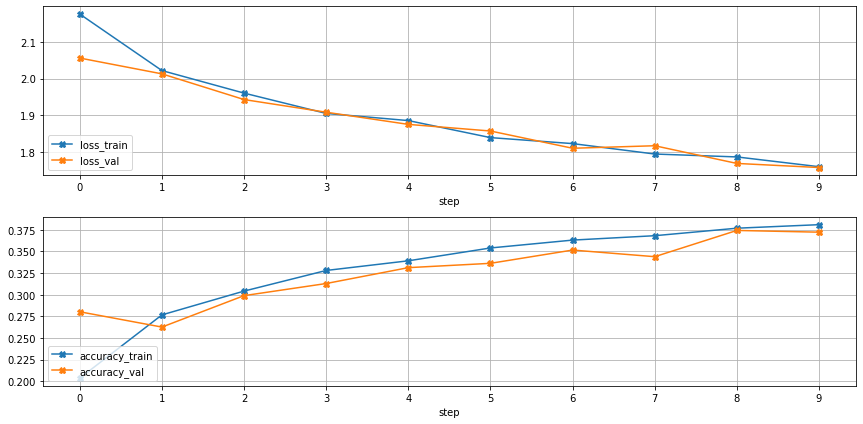

In [28]:
model = FCNet()  # Create model instance
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10)

In [29]:
accuracy = max(pp.history_dict['accuracy_val'])
print(f"Accuracy {accuracy:.2f}")

Accuracy 0.37


# Задание 2. Нормализация данных

Стандартизируем данные.

* Подсчитаем среднее значение и стандартное отклонение для каждого из 3-х цветовых каналов 
 * Сделаем это с помощью встроенных в torch или numpy функций
* Нормализуем данные с использованием этих параметров (будем юзать трансформацию Normalize)
* Оценим влияние нормировки данных на точность обучения. (Сравним результаты обучения на сырых данных и на стандартизованных)

In [30]:
for imgs, labels in train_loader: 
    img_ex=imgs[5]
    break
print(img_ex.shape)
print(img_ex[0,:,:])

torch.Size([3, 32, 32])
tensor([[0.2353, 0.3098, 0.3333,  ..., 0.1373, 0.1412, 0.1255],
        [0.1647, 0.2510, 0.2235,  ..., 0.1137, 0.1020, 0.0588],
        [0.1961, 0.2314, 0.1922,  ..., 0.1333, 0.1725, 0.0902],
        ...,
        [0.5961, 0.5922, 0.5843,  ..., 0.7882, 0.7686, 0.7176],
        [0.6275, 0.7176, 0.7725,  ..., 0.7451, 0.7490, 0.7451],
        [0.5922, 0.6392, 0.6667,  ..., 0.7725, 0.7725, 0.7569]])


In [31]:
dataset.data.shape

(50000, 32, 32, 3)

In [32]:
from torchvision import transforms

# mean=np.mean(dataset.data,(0,1,2)) # Но вообще я ведь должен обучать скейлер только на трейне?
# std=np.std(dataset.data,(0,1,2))

 #выкачать все из трен даталоадре, положить в массив и все...

lst=[]
for imgs, labels in train_loader:
    for img in imgs:
        lst.append(img.numpy())

tr=np.array(lst)
print(tr.shape)

mean=np.mean(tr,(0,2,3))
std=np.std(tr,(0,2,3))

print(mean,std)

normalize = transforms.Normalize(mean,std)


(12000, 3, 32, 32)
[0.49251205 0.4830074  0.447451  ] [0.24656862 0.24265024 0.26113993]


In [33]:
#?torchvision.transforms.ToTensor

In [34]:
normalize = transforms.Normalize(mean,std)
#for imgs, labels in train_loader:
#    for img in imgs:
#        img = normalize(img)

#for imgs, labels in val_loader:
#    for img in imgs:
#        img = normalize(img)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize]) 

dataset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform) #dataset.data
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)


trainset, valset, _  = random_split(dataset, [12000, 3000, 35000])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
#for imgs, labels in train_loader: 
#    img_ex2=imgs[5]
#    break
#print(img_ex==img_ex2)

Теперь опять просто натренируем нашу сетку.

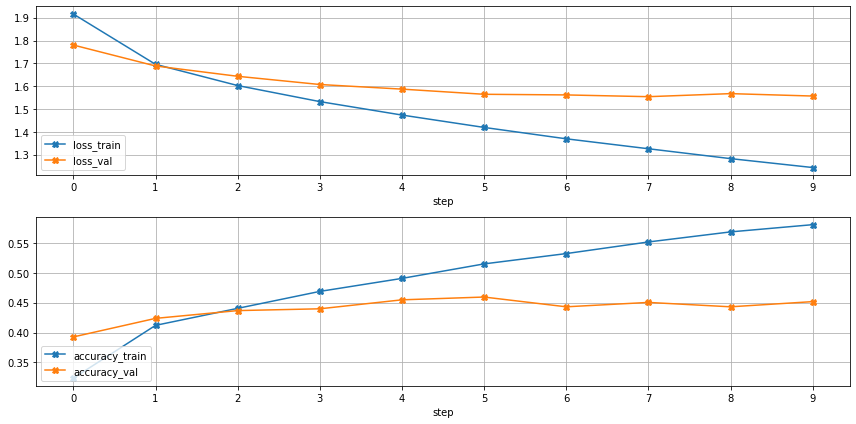

Accuracy 0.46


In [36]:
model = FCNet()  # Create model instance
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10)

accuracy = max(pp.history_dict['accuracy_val'])
print(f"Accuracy {accuracy:.2f}")

# Задание 3. Влияние функций активации

* Исследуем влияние функций активации на скорость обучения и точность предсказаний модели.

* Используем три функции:

 * [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
 * [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
 * [ReLU](https://pytorch.org/docs/stable/nn.functional.html#relu)
* Построим графики потерь loss для разных функций активации в одних осях.

* В принципе можем модифировать конструктор класса сети, чтобы была возможность передать туда желаемую функцию активации.

In [37]:
class FCNet(nn.Module):
    def __init__(self,act):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 500) # учитываум, что у нас RGB
        self.fc2 = nn.Linear(500, 10)
        self.activation = act()

    def forward(self, x):
        x = x.view(-1, 32*32*3) # картинку превращаем в массив пикселей
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [38]:
model1 = FCNet(nn.Sigmoid) 
model2 = FCNet(nn.GELU) 
model3 = FCNet(nn.ReLU) 

def train(model, criterion, optimizer, num_epochs=10, tag="cifar10"):
    loss_val=[]
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        for imgs, labels in train_loader:     
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            correct += get_correct_count(outputs,labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            ep_loss += loss.item()
        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_loader))
        pp.add_scalar('accuracy_train', correct/total)

        accuracy, loss_val_loc = calaculate_accuracy(model,val_loader,criterion)
        loss_val.append(loss_val_loc)
        #if j==1:
        #    str='Sigmoid'
        #if j==2:
        #    str='GELU'
        #if j==3:
        #    str='ReLU'
        
        #str_fin='val_loss for'+'_'+str
        #pp.add_scalar(str_fin,loss_val_loc)

        #pp.display([['loss_val_Sigmoid','loss_val_GELU','loss_val_ReLU',]])
    return loss_val




In [39]:
#i=1
loss_val_per_model=[]
pp = ProgressPlotter()
for model_x in [model1,model2,model3]:
    model_x.train()
    optimizer = torch.optim.SGD(model_x.parameters(), lr=0.05)  # Weight update
    criterion = nn.CrossEntropyLoss() # Loss function
    lv = train(model_x, criterion, optimizer, num_epochs=10) # добавить прогрессплоттер мб?
    #print(type(lv),lv)
    loss_val_per_model.append(lv)
    #i+=1

#print(type(loss_val_per_model),loss_val_per_model)




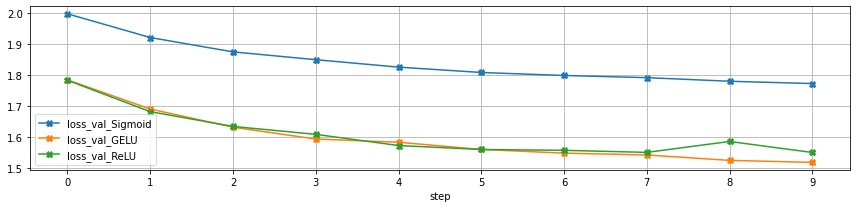

In [40]:
i=0
for epoch in range(10):
    pp.add_scalar('loss_val_Sigmoid', loss_val_per_model[0][i])
    pp.add_scalar('loss_val_GELU', loss_val_per_model[1][i])
    pp.add_scalar('loss_val_ReLU', loss_val_per_model[2][i])

    pp.display([['loss_val_Sigmoid','loss_val_GELU','loss_val_ReLU',]])
    i+=1

# Задание 4. Классифицировать CIFAR10 с максимальной точностью

Для этого:

*  Стандартизировать данные
*  Подобрать шаг обучения
*  Использовать весь датасет для обучения
*  При необходимости поменять архитектуру модели


In [41]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform) #dataset.data
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)


trainset, valset = random_split(dataset, [40000, 10000])

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

lst=[]
for imgs, labels in train_loader:
    for img in imgs:
        lst.append(img.numpy())

tr=np.array(lst)
print(tr.shape)

mean=np.mean(tr,(0,2,3))
std=np.std(tr,(0,2,3))

print(mean,std)

normalize = transforms.Normalize(mean,std)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize]) 

dataset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform) #dataset.data
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)


trainset, valset = random_split(dataset, [40000, 10000])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified
(40000, 3, 32, 32)
[0.49128932 0.48198283 0.44638973] [0.24703112 0.24352774 0.26167065]
Files already downloaded and verified
Files already downloaded and verified


In [42]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 500) # учитываем, что у нас RGB
        self.fc2 = nn.Linear(500, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32*32*3) # картинку превращаем в массив пикселей
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [43]:
def train(model, criterion, optimizer, num_epochs=10, tag="cifar10"):
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        for imgs, labels in train_loader:     
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            correct += get_correct_count(outputs,labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            ep_loss += loss.item()
        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_loader))
        pp.add_scalar('accuracy_train', correct/total)

        accuracy, loss_val = calaculate_accuracy(model,val_loader,criterion)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('accuracy_val',accuracy)

        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
    return pp

Оцениваем точность на тестовом датасете

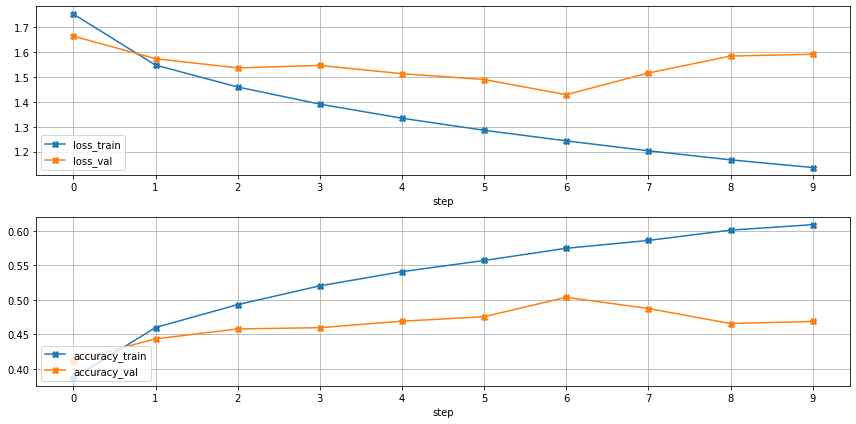

Accuracy 0.50


In [44]:
model = FCNet()  # Create model instance
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10)

accuracy = max(pp.history_dict['accuracy_val'])
print(f"Accuracy {accuracy:.2f}")